In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

import cv2
from torchvision import datasets
import torch
import torchvision
import torchvision.transforms as transforms
import imutils
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
from imutils.video import VideoStream
Image.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [10]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"
test_dataset_path = os.path.join(base_path, "test dataset videos")

# Exploratory Data Analysis

## Testing dataset

To create models that can predict the presence of fire in images, we first need to create a testing dataset that is not changed nor used to train the models. This allows for a testing process that is not changed and which the models do not know.

Since the models are to be used in cameras that are 99% of the time looking at forested areas, it makes sense to have a testing dataset that is a sequence of images obtained from videos that show the progression of a fire or that simply do not have any fires whatsoever.

To that end, we decided to create the testing dataset out of a series of videos obtained from the internet. Next is the list of videos used to create the dataset:

Fire videos:

 - "Raging Wildfires Burn Across Canada Sending Smoke Down to the US", https://www.youtube.com/watch?v=bUfwUnin9DE
 - "Bighorn Fire Timelapse 6-17-2020", https://www.youtube.com/watch?v=UdMHoyqvQXA
 - "Inside a Wildfire - Dramatic Drone Footage! Ep. 193a.", https://www.youtube.com/watch?v=gA27ZI-_gCA
 - "Wildfire Forest Fire (FREE STOCK VIDEO)", https://www.youtube.com/watch?v=3kfA4sXoFag
 - "Aerial Footage Shows Scale of Fires in Australia", https://www.youtube.com/watch?v=DQpBiYI_7M0

Non-fire videos:

 - "Amazing Storm Timelapse", https://www.youtube.com/watch?v=TgYCtOpbLSo
 - "NEMUS - 4K Forest Time-Lapse", https://www.youtube.com/watch?v=gcnsGDsc_PI
 - "THE FOREST - A Time-Lapse Journey Through the Forgotten Norway 4K", https://www.youtube.com/watch?v=xUesKDDcLoQ
 - "Forming cumulonimbus (timelapse)", https://www.youtube.com/watch?v=232LFz-aiz4
 - "DARK FOG | Cinematic Video", https://www.youtube.com/watch?v=VMn-T-FCr9g

Let's run a fire and a non_fire video and see how they run

In [3]:
def run_video(filename):
    cap = cv2.VideoCapture(filename)

    while True:
        ret, image = cap.read()

        # Check if the frame was successfully read
        if not ret:
            break
        
            
        cv2.putText(image, "PRESS Q TO EXIT", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame
        cv2.imshow('framename', image)

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [7]:
fire_video = os.path.join(test_dataset_path, "timelapse.mp4")

# PRESS Q TO EXIT VIDEO

run_video(fire_video)

In [8]:
non_fire_video = os.path.join(test_dataset_path, "storm_timelapse.mp4")

# PRESS Q TO EXIT VIDEO

run_video(non_fire_video)

Nice. However, just passing the model through the videos will not be enough to observe if the model is accurate in statistic terms, only with a human visual interpretation.

To check statistically, we need to check the percentage of times that the model correctly predicted the presence of fire in the frames of the video. For that, we need to have a label pre-defined for each frame. To do this, we need to split the videos into a sequence of images and label the images accordingly.

To split the videos into images, we will use ffmpeg (https://ffmpeg.org), which is a command line program. We will run the following command for all videos of the dataset:

ffmpeg -i ..\[video_name].mp4 -vf fps=2 out%d.png

This line:

 - forcefully (-vf) converts the .mp4 file into a sequence of .png files, and 
 - obtains 2 .png images per second of video

Once all videos are converted, we need to go each frame one at a time and manually label them according to the presence of fire in the frame.

This was done by doing the filtering and also by deleting any frames that did not have live footage, such as video intros, video outros, black frames, and frames that only consist of the channel label.

Let's check how it turned out.

In [9]:
os.listdir(test_dataset_path)

['cloud_forming',
 'cloud_forming.mp4',
 'drone_footage',
 'drone_footage.mp4',
 'firefighting',
 'firefighting.mp4',
 'forest_timelapse_2',
 'forest_timelapse_2.mp4',
 'forest_time_lapse_1',
 'forest_time_lapse_1.mp4',
 'forest_video',
 'forest_video.mp4',
 'stock_footage',
 'stock_footage.mp4',
 'storm_timelapse',
 'storm_timelapse.mp4',
 'timelapse',
 'timelapse.mp4',
 'voa_fire',
 'voa_fire.mp4']

In [12]:
total_images = 0
fire_images = 0
non_fire_images = 0

for folder in os.listdir(test_dataset_path):
    if ".mp4" in folder:
        continue
    for label in os.listdir(os.path.join(test_dataset_path, folder)):
        count = len(os.listdir(os.path.join(test_dataset_path, folder, label)))
        print(folder + "\\" + label, count)

        if label == "fire_images":
            fire_images += count
        else:
            non_fire_images += count

        total_images += count
    print("")

cloud_forming\fire_images 0
cloud_forming\non_fire_images 207

drone_footage\fire_images 509
drone_footage\non_fire_images 32

firefighting\fire_images 181
firefighting\non_fire_images 0

forest_timelapse_2\fire_images 0
forest_timelapse_2\non_fire_images 454

forest_time_lapse_1\fire_images 0
forest_time_lapse_1\non_fire_images 248

forest_video\fire_images 0
forest_video\non_fire_images 628

stock_footage\fire_images 50
stock_footage\non_fire_images 0

storm_timelapse\fire_images 0
storm_timelapse\non_fire_images 233

timelapse\fire_images 232
timelapse\non_fire_images 112

voa_fire\fire_images 110
voa_fire\non_fire_images 0



In [13]:
print("Total images: ", total_images)

Total images:  2996


In [18]:
labels = ["fire images", "non fire images"]
counts = [fire_images, non_fire_images]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])

bar_trace = go.Bar(
    x = labels,
    y = counts,
    marker_color = ['darkorange','green'],
    text = [str(count) for count in counts],
    showlegend = False)

fig.add_trace(bar_trace,row=1,col=1)

fig.add_trace(go.Pie(
     values = counts,
     labels=labels,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)

In [29]:
# Pie chart
pie_trace = go.Pie(
    values=counts,
    labels=labels,
    marker=dict(colors=['darkorange', 'green']),
)

fig_pie = go.Figure(data=[pie_trace])
fig_pie.update_layout(width=1000, height=700, font=dict(size=32))
fig_pie.show()

2 times more non-fire images than fire images. This dataset can even be used for an overall initial evaluation based only on the images, before evaluating based on video prediction accuracy.

Let's also add these images to an overall testing dataset to calculate initial metrics.

In [19]:
import shutil

In [20]:
overall_test_path = os.path.join(base_path, "test dataset")

In [5]:
try:
    shutil.rmtree(overall_test_path)
    print(f"Deleted folder: {overall_test_path}")
except Exception as e:
    print(f"Error deleting folder {overall_test_path}: {e}")

os.makedirs(overall_test_path, exist_ok=True)

Deleted folder: C:\Users\johnn\Desktop\Repos\Capstonfire\test dataset


In [6]:
fire_overall_test_path = os.path.join(overall_test_path, "fire_images")
os.makedirs(fire_overall_test_path, exist_ok=True)

non_fire_overall_test_path = os.path.join(overall_test_path, "non_fire_images")
os.makedirs(non_fire_overall_test_path, exist_ok=True)

Might make sense to rename the files before copying, since all images have the format "out%d" from the ffmpeg output.

In [7]:
for idx, folder in enumerate(os.listdir(test_dataset_path)):
    if ".mp4" in folder:
        continue
    for label in os.listdir(os.path.join(test_dataset_path, folder)):
        for filename in os.listdir(os.path.join(test_dataset_path, folder, label)):
            full_file_path = os.path.join(test_dataset_path, folder, label, filename)
            new_file_name = os.path.join(test_dataset_path, folder, label, str(idx) + filename)
            os.rename(full_file_path,  new_file_name)
            if label == "fire_images":
                shutil.copy2(new_file_name, fire_overall_test_path)
            else:
                shutil.copy2(new_file_name, non_fire_overall_test_path)

In [8]:
for dirname, _, filenames in os.walk(overall_test_path):
    print(len(filenames))

0
1082
1914


Nice, it worked. Now we have an overall testing dataset and a video testing dataset.

Now we are ready to start creating models!

In [21]:
df_full = pd.DataFrame(columns=['path', 'label', 'width', 'height'])

for dirname, _, filenames in os.walk(overall_test_path):
    for filename in filenames:
        image_shape = Image.open(dirname + "\\" + filename).size
        height = image_shape[1]
        width = image_shape[0]
        df_full = pd.concat([df_full, pd.DataFrame([[os.path.join(dirname, filename),'fire', width, height]], columns=['path','label', 'width', 'height'])], axis=0)

for dirname, _, filenames in os.walk(overall_test_path):
    for filename in filenames:
        image_shape = Image.open(dirname + "\\" + filename).size
        height = image_shape[1]
        width = image_shape[0]
        df_full = pd.concat([df_full, pd.DataFrame([[os.path.join(dirname, filename),'no fire', width, height]],columns=['path','label', 'width', 'height'])], axis=0)

df_full = df_full.sample(frac=1).reset_index(drop=True)
df_full.head(10)

,path,label,width,height
0,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,fire,854,480
1,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480
2,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,1280,720
3,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480
4,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480
5,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,1280,720
6,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,fire,854,480
7,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,fire,854,480
8,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480
9,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480


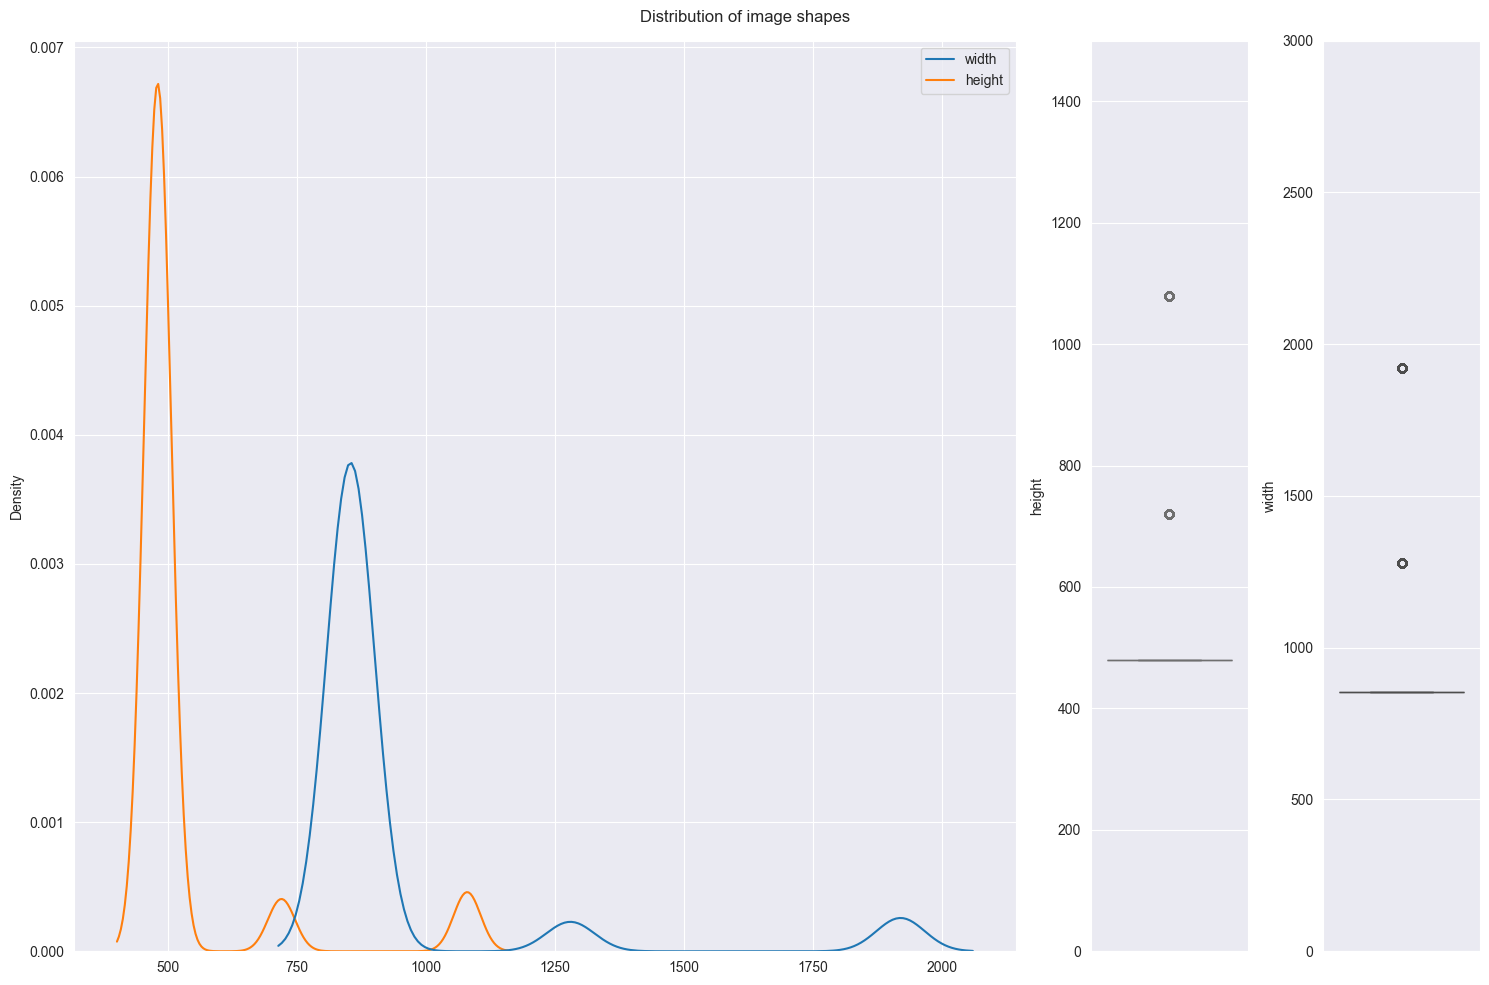

In [22]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df_full.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df_full,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df_full,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,3000)
ax2.set_ylim(0,1500)
plt.tight_layout()

In [23]:
df_full_ratio = df_full.copy()
df_full_ratio['ratio'] = np.where(df_full['width'] > df_full['height'], df_full['width'] / df_full['height'], df_full['height'] / df_full['width'])
df_full_ratio

,path,label,width,height,ratio
0,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,fire,854,480,1.779167
1,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480,1.779167
2,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,1280,720,1.777778
3,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480,1.779167
4,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480,1.779167
...,...,...,...,...,...
5987,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480,1.779167
5988,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,854,480,1.779167
5989,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,no fire,1920,1080,1.777778
5990,C:\Users\johnn\Desktop\Repos\Capstonfire\test ...,fire,854,480,1.779167


In [26]:
df_full_ratio['ratio'].value_counts()

ratio
1.7791666666666666    5310
1.7777777777777777     682
Name: count, dtype: int64

Every image has an aspect ratio of 16:9.